In [897]:
from IPython.display import HTML
HTML('''<script>code_show=true;function code_toggle(){if(code_show){$('.prompt, .output_stderr, .output_error').hide();}else{$('.input, .prompt, .output_stderr, .output_error').show();}code_show=!code_show}$(document).ready(code_toggle);</script>
To toggle on/off the raw code, click
<a href="javascript:code_toggle()">here</a>.''')

# Section 1: Packages

In [579]:
import os
import sys
import warnings

warnings.filterwarnings('ignore')
if sys.platform == "darwin":
    %config InlineBackend.figure_format = 'retina'
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import json
import time
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib as mpl
from sklearn.svm import SVC
from functools import reduce
from itertools import product
from collections import Counter
from xgboost import XGBClassifier
from urllib.request import urlopen
from matplotlib import pyplot as plt
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from multiprocessing import set_start_method
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap as cmap
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
                             VotingClassifier, RandomForestClassifier, AdaBoostClassifier


plt.rcParams.update(mpl.rcParamsDefault)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.facecolor'] = 'f4f4f4'
plt.rcParams['font.family'] = 'Palatino'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['lines.linewidth'] = 2
pd.options.display.max_rows = 20

# Section 2: Functions

In [837]:
def yahoo_parser(url):
    response = urlopen(url)
    data = json.loads(response.read().decode("utf-8"))['chart']['result'][0]
    t = pd.to_datetime(data['timestamp'], unit='s').date
    c = data['indicators']['quote'][0]['close']
    return pd.DataFrame({'close': c}, index=t)


def default_parser(url):
    return pd.read_csv(url, index_col=0, parse_dates=True)


def retrieve(source, code, label, column=None):
    query = {
        'fred': 'https://fred.stlouisfed.org/graph/fredgraph.csv?id={}',
        'yahoo': 'https://query1.finance.yahoo.com/v8/finance/chart/{}?period1=500000000&period2=2000000000&interval=1d',
        'quandl': 'https://www.quandl.com/api/v3/datasets/{}.csv?api_key=ZtDUGt7_qj48rgupCAid',
        'worldbank': 'http://api.worldbank.org/v2/en/indicator/{}?downloadformat=csv',
        'csv': '{}.csv',
    }
    parser = {
        'yahoo': yahoo_parser,
    }
    url = query.get(source).format(code)
    df = parser.get(source, default_parser)(url)
    df.index.name = None
    df.columns = [col.lower() for col in df.columns] if df.shape[1] > 1 else [label]
    if not column: column = df.columns
    all_dates = pd.date_range(df.index.min(), df.index.max(), freq='D')
    df = df.replace('.', None).reindex(all_dates).fillna(method='ffill')
    return df.astype('float')[column].squeeze()


def new_feature(val, name):
    val.name = name
    return val


class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        self.thresh = thresh
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with VIF={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), ha="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Section 3: Data Preparation

In [829]:
bd = retrieve('fred', 'BAMLC0A1CAAAEY', 'bd')   # bond yield
tr10 = retrieve('fred', 'DGS10', 'tr10')        # 10-year treasury
tr2 = retrieve('fred', 'DGS2', 'tr2')           # 2-year treasury
sp500 = retrieve('yahoo', '^GSPC', 'sp500')     # S&P 500 close
vix = retrieve('yahoo', '^VIX', 'vix')          # VIX close
dr = retrieve('csv', 'DR', 'dr')                # default rate
d2g = retrieve('csv', 'D2G', 'd2g')             # debt to GDP
ip = retrieve('fred', 'A091RC1Q027SBEA', 'ip')  # interest payment
rf = retrieve('fred', 'INTDSRUSM193N', 'rf')    # interest rate
gdp = retrieve('fred', 'GDP', 'gdp')            # GDP

In [855]:
max_len = 8000  # maximum length of whole dataset
forecast = 1    # forecast the direction of dcs in n days
nlags = 3       # maximum number of lags for lagged terms

# create dataframe
i2g = new_feature(ip / gdp, 'i2g')                        # interest payment (% gdp)
cs = new_feature(bd - tr10, 'cs')                         # credit spread
dcs = new_feature(cs.diff(), 'dcs')                       # 1st order difference of cs
ecs = new_feature((rf + dr) / (1 - dr) - rf, 'ecs')       # estimated cs
edcs = new_feature(ecs.diff(), 'edcs')                    # estimated dcs
spr = new_feature(sp500 / sp500.shift(20) - 1, 'spr')     # sp500 monthly return
syc = new_feature(tr10 - tr2, 'syc')                      # slope of yield curve

# assemble features
df = bd.to_frame().join([tr10, spr, vix, dr, d2g, i2g, dcs, edcs, syc])
print('Features before lagging ({} in total):'.format(df.shape[1]))
print(df.columns.tolist())

# add lagged terms
for col in df.columns[:-1]:
    for i in range(1, nlags + 1):
        col_name = col + ('_' + str(i))
        col_val = df[col].shift(i)
        df[col_name] = col_val

f = lambda x: int(x > 0)

df['y'] = np.vectorize(f)(df['dcs'].shift(-forecast))  # y = 1 if tmr's dcs is positive
df.reindex(sorted(df.columns.tolist()), axis=0)
idx = df.index
print('-' * 117)
print('Features including lagged variables ({} in total):'.format(df.shape[1]))
print(df.columns.tolist()[:-1])
print('-' * 117)

# sovle colinearity by VIF reduction
rv = ReduceVIF()
keep_cols = ['vix', 'y']
df_ = rv.fit_transform(df[[col for col in df.columns if col not in keep_cols]])
df_.index = idx
df = df_.join(df[keep_cols])

# drop nan, then truncate to max_len
df = df.replace({np.inf: np.nan, -np.inf: np.nan}).dropna().iloc[-max_len:, :]
mask = (df.std() < 1e-10)  # drop constant variables
df = df.loc[:, ~mask]
print('-' * 117)
print('Features after reduction ({} in total):'.format(df.shape[1]))
print(df.columns.tolist()[:-1])

df.iloc[:, :-1] = df.iloc[:, :-1].apply(lambda x: x / x.std())
df.describe().round(4).loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]

Features before lagging (10 in total):
['bd', 'tr10', 'spr', 'vix', 'dr', 'd2g', 'i2g', 'dcs', 'edcs', 'syc']
---------------------------------------------------------------------------------------------------------------------
Features including lagged variables (38 in total):
['bd', 'tr10', 'spr', 'vix', 'dr', 'd2g', 'i2g', 'dcs', 'edcs', 'syc', 'bd_1', 'bd_2', 'bd_3', 'tr10_1', 'tr10_2', 'tr10_3', 'spr_1', 'spr_2', 'spr_3', 'vix_1', 'vix_2', 'vix_3', 'dr_1', 'dr_2', 'dr_3', 'd2g_1', 'd2g_2', 'd2g_3', 'i2g_1', 'i2g_2', 'i2g_3', 'dcs_1', 'dcs_2', 'dcs_3', 'edcs_1', 'edcs_2', 'edcs_3']
---------------------------------------------------------------------------------------------------------------------
Dropping dr_1 with VIF=1350056.7645003789
Dropping dr_2 with VIF=992373.2604754055
Dropping bd_2 with VIF=623906.6109502116
Dropping bd_1 with VIF=485275.22427384724
Dropping bd_3 with VIF=124173.21672373342
Dropping i2g_2 with VIF=40170.022685301454
Dropping i2g_1 with VIF=29973.47265229

bd     spr      dr      dcs     edcs     syc   spr_3    dcs_1  \
mean  2.6859  0.0964  1.5155   0.0013  -0.0006  1.3205  0.0961   0.0014   
std   1.0000  1.0000  1.0000   1.0000   1.0000  1.0000  1.0000   1.0000   
min   0.9453 -7.4004  0.3602 -30.7310 -12.0375 -0.5627 -7.4033 -30.7319   
25%   1.7708 -0.3967  0.8012  -0.3409  -0.0216  0.3138 -0.3968  -0.3409   
50%   2.6783  0.1854  1.1041   0.0000  -0.0004  1.4066  0.1852   0.0000   
75%   3.4598  0.6697  1.9914   0.3409   0.0183  2.1641  0.6698   0.3409   
max   5.1991  5.7091  4.9001  31.0363  12.0375  3.1487  5.7113  31.0372   

        dcs_2    dcs_3   edcs_1   edcs_2   edcs_3     vix       y  
mean   0.0014   0.0014  -0.0006  -0.0006  -0.0007  2.4163  0.2859  
std    1.0000   1.0000   1.0000   1.0000   1.0000  1.0000  0.4519  
min  -30.7319 -30.7319 -12.0375 -12.0375 -12.0374  1.0910  0.0000  
25%   -0.3409  -0.3409  -0.0216  -0.0217  -0.0217  1.6723  0.0000  
50%    0.0000   0.0000  -0.0004  -0.0004  -0.0004  2.2393  0.0000  
75%    0.3409   0.3409   0.0183   0.0183   0.0183  2.8672  1.0000  
max   31.0372  31.0372  12.0375  12.0375  12.0374  9.6519  1.0000

In [840]:
X = df.drop('y', axis=1)
y = df.y
sampler = SMOTETomek(random_state=0)
X, y = sampler.fit_resample(X, y)
X = X[:max_len]
y = y[:max_len]
df_ = df.copy()
df_.iloc[:, :-1] = X
df_.iloc[:, -1] = y
sns.pairplot(df_, vars=df_.columns, hue='y', palette={0:'r', 1:'k'}, height=3, plot_kws={'edgecolor': 'none'})
plt.show()

# Section 4: Feature Engineering

In [856]:
max_features = 10

#### Generate `X` and `y`.

In [857]:
X = df.drop('y', axis=1)
y = df.y
print(X.columns.tolist())

['bd', 'spr', 'dr', 'dcs', 'edcs', 'syc', 'spr_3', 'dcs_1', 'dcs_2', 'dcs_3', 'edcs_1', 'edcs_2', 'edcs_3', 'vix']


#### Variance Ranking.

In [858]:
vt = VarianceThreshold().fit(X)
ranks = (-vt.variances_).argsort().argsort()
feat_var = X.columns[ranks<max_features]
print(feat_var.tolist())

['bd', 'spr', 'dr', 'dcs', 'edcs', 'dcs_1', 'dcs_2', 'dcs_3', 'edcs_3', 'vix']


#### Random Forest.

In [859]:
model = RandomForestClassifier()
model.fit(X, y)
feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feat_imp = feature_imp.sort_values('importance', ascending=False).head(max_features).index
print(feat_imp.tolist())

['spr_3', 'spr', 'vix', 'bd', 'dr', 'syc', 'edcs_2', 'edcs_3', 'edcs_1', 'edcs']


#### $\chi^2$ Test.

In [860]:
X_minmax = MinMaxScaler([0, 1]).fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, y)
feature_scoring = pd.DataFrame({'feature': X.columns,'score': X_scored.scores_})
feat_scored = feature_scoring.sort_values('score', ascending=False).head(max_features)['feature'].values
print(feat_scored.tolist())

['dr', 'vix', 'syc', 'bd', 'spr', 'spr_3', 'dcs_2', 'dcs_3', 'edcs_2', 'edcs_3']


#### Recursive Feature Elimination (RFE)

with Logistic Regression model.

In [861]:
rfe = RFE(LogisticRegression(), max_features)
rfe.fit(X, y)
feature_rfe_scoring = pd.DataFrame({'feature': X.columns,'score': rfe.ranking_})
feat_rfe = feature_rfe_scoring[feature_rfe_scoring['score']==1]['feature'].values
print(feat_rfe.tolist())

['spr', 'dr', 'dcs', 'syc', 'spr_3', 'dcs_1', 'dcs_2', 'dcs_3', 'edcs_2', 'vix']


#### Final Selection of Features

is the union of all previous sets.

In [862]:
features = np.unique(np.hstack([feat_var, feat_imp, feat_scored, feat_rfe]))
print('Final features ({} in total):'.format(len(features)))
print(features)

Final features (14 in total):
['bd' 'dcs' 'dcs_1' 'dcs_2' 'dcs_3' 'dr' 'edcs' 'edcs_1' 'edcs_2' 'edcs_3'
 'spr' 'spr_3' 'syc' 'vix']


# Section 5: Model Training

#### Prepare data for training

In [863]:
df_model = df.loc[:, features.tolist() + ['y']]
df_model.round(4)

bd     dcs   dcs_1   dcs_2   dcs_3      dr    edcs  edcs_1  \
1997-02-28  4.3672  1.7031  0.0000  0.0000 -0.0000  0.6600 -0.1259 -0.1255   
1997-03-01  4.3672  0.0000  1.7031  0.0000  0.0000  0.6594 -0.1263 -0.1259   
1997-03-02  4.3672  0.0000  0.0000  1.7031  0.0000  0.6589 -0.1267 -0.1263   
1997-03-03  4.3735 -0.3409  0.0000  0.0000  1.7031  0.6584 -0.1271 -0.1267   
1997-03-04  4.3925  0.3409 -0.3409  0.0000  0.0000  0.6579 -0.1276 -0.1271   
1997-03-05  4.3862 -0.3409  0.3409 -0.3409  0.0000  0.6573 -0.1280 -0.1276   
1997-03-06  4.4051  0.3409 -0.3409  0.3409 -0.3409  0.6568 -0.1284 -0.1280   
1997-03-07  4.3735  0.0000  0.3409 -0.3409  0.3409  0.6563 -0.1288 -0.1284   
1997-03-08  4.3735  0.0000  0.0000  0.3409 -0.3409  0.6558 -0.1293 -0.1288   
1997-03-09  4.3735  0.0000  0.0000  0.0000  0.3409  0.6552 -0.1297 -0.1293   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2019-01-14  2.2120  0.3409  0.0000  0.0000  0.3409  0.7849 -0.0004 -0.0004   
2019-01-15  2.2120 -0.3409  0.3409  0.0000  0.0000  0.7844 -0.0004 -0.0004   
2019-01-16  2.2120 -0.3409 -0.3409  0.3409  0.0000  0.7839 -0.0004 -0.0004   
2019-01-17  2.2057 -1.0224 -0.3409 -0.3409  0.3409  0.7834 -0.0004 -0.0004   
2019-01-18  2.2057 -1.3629 -1.0224 -0.3409 -0.3409  0.7829 -0.0004 -0.0004   
2019-01-19  2.2057  0.0000 -1.3629 -1.0224 -0.3409  0.7824 -0.0004 -0.0004   
2019-01-20  2.2057  0.0000  0.0000 -1.3629 -1.0224  0.7819 -0.0004 -0.0004   
2019-01-21  2.2057  0.0000  0.0000  0.0000 -1.3629  0.7814 -0.0004 -0.0004   
2019-01-22  2.1742  0.0000  0.0000  0.0000  0.0000  0.7809 -0.0004 -0.0004   
2019-01-23  2.1742 -0.6817  0.0000  0.0000  0.0000  0.7804 -0.0004 -0.0004   

            edcs_2  edcs_3     spr   spr_3     syc     vix  y  
1997-02-28 -0.1251 -0.1247  0.0417  1.1323  0.5086  2.5186  0  
1997-03-01 -0.1255 -0.1251  0.0417  0.8545  0.5086  2.5186  0  
1997-03-02 -0.1259 -0.1255  0.1791  0.1822  0.5086  2.5186  0  
1997-03-03 -0.1263 -0.1259  0.1891  0.0417  0.5086  2.4935  1  
1997-03-04 -0.1267 -0.1263 -0.3843  0.0417  0.5302  2.4613  0  
1997-03-05 -0.1271 -0.1267 -0.3160  0.1792  0.5086  2.3264  1  
1997-03-06 -0.1276 -0.1271 -0.3203  0.1892  0.5086  2.4446  0  
1997-03-07 -0.1280 -0.1276 -0.1133 -0.3845  0.5086  2.3061  0  
1997-03-08 -0.1284 -0.1280 -0.1133 -0.3162  0.5086  2.3061  0  
1997-03-09 -0.1288 -0.1284 -0.1133 -0.3204  0.5086  2.3061  1  
...            ...     ...     ...     ...     ...     ... ..  
2019-01-14 -0.0004 -0.0004  2.5701  1.9409  0.1948  2.2763  0  
2019-01-15 -0.0004 -0.0004  1.5083  1.9409  0.2056  2.2202  0  
2019-01-16 -0.0004 -0.0004  1.3347  2.7227  0.1948  2.2727  0  
2019-01-17 -0.0004 -0.0004  1.5773  2.5711  0.2056  2.1557  0  
2019-01-18 -0.0004 -0.0004  1.9422  1.5088  0.1839  2.1247  0  
2019-01-19 -0.0004 -0.0004  1.9422  1.3352  0.1839  2.1247  0  
2019-01-20 -0.0004 -0.0004  1.7061  1.5779  0.1839  2.1247  0  
2019-01-21 -0.0004 -0.0004  1.7061  1.9429  0.1839  2.1247  0  
2019-01-22 -0.0004 -0.0004  1.2777  1.9429  0.1731  2.4828  0  
2019-01-23 -0.0004 -0.0004  2.0345  1.7067  0.1948  2.3300  0  

[8000 rows x 15 columns]

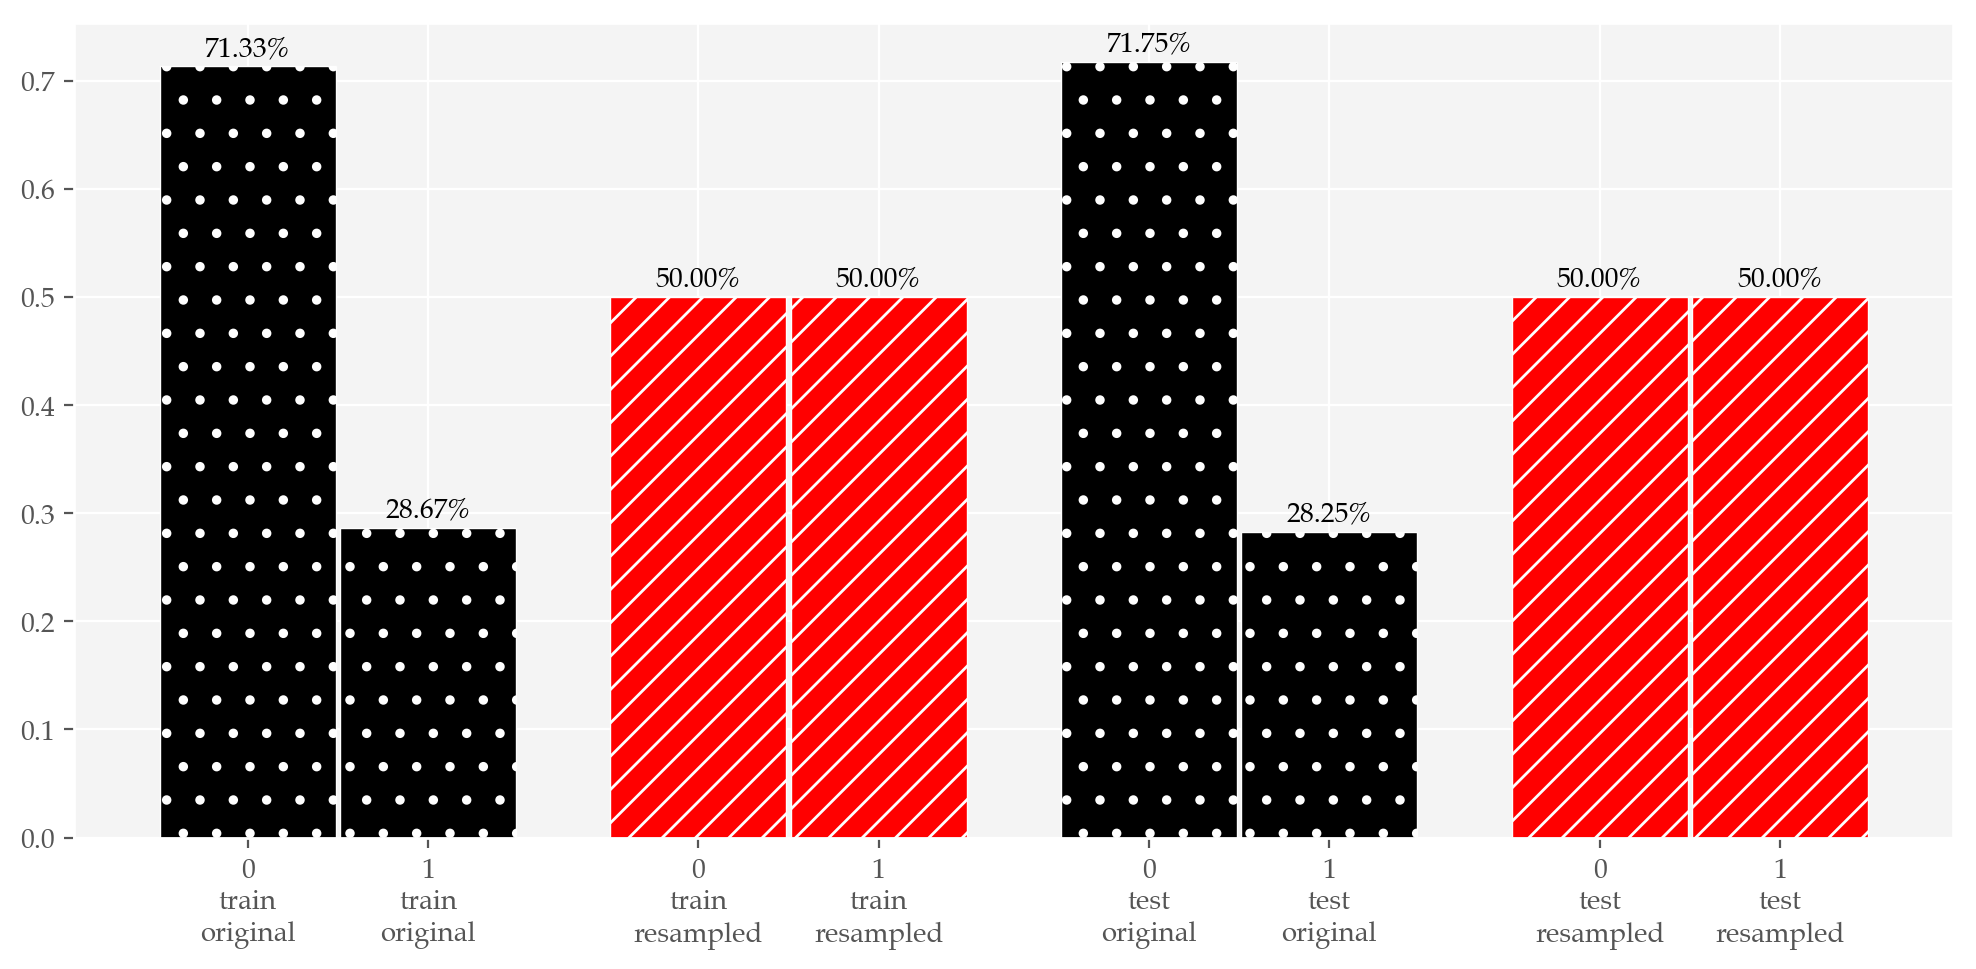

In [866]:
X = df_model[features].values
y = df_model['y'].values

val_split = .2
val_len = round(max_len * val_split)
y_train = y[:-val_len]
X_train = X[:-val_len]
y_test = y[-val_len:]
X_test = X[-val_len:]

r1_train = np.array(list(Counter(y_train).values())) / len(y_train)
r1_test = np.array(list(Counter(y_test).values())) / len(y_test)

X_train, y_train = sampler.fit_resample(X_train, y_train)
X_test, y_test = sampler.fit_resample(X_test, y_test)

r2_train = np.array(list(Counter(y_train).values())) / len(y_train)
r2_test = np.array(list(Counter(y_test).values())) / len(y_test)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar([0.0, 0.2], r1_train, hatch='.', edgecolor='#fefefe', width=.195, color='k')
ax.bar([0.5, 0.7], r2_train, hatch='//', edgecolor='#fefefe', width=.195, color='r')
ax.bar([1.0, 1.2], r1_test,  hatch='.', edgecolor='#fefefe', width=.195, color='k')
ax.bar([1.5, 1.7], r2_test,  hatch='//', edgecolor='#fefefe', width=.195, color='r')
ax.set_xticklabels(['0\ntrain\noriginal', '1\ntrain\noriginal', '0\ntrain\nresampled', '1\ntrain\nresampled',
                    '0\ntest\noriginal', '1\ntest\noriginal', '0\ntest\nresampled', '1\ntest\nresampled'])
ax.set_xticks([0, 0.2, 0.5, 0.7, 1, 1.2, 1.5, 1.7])
ax.text(0.0, r1_train[0] + .01, '{:.2f}%'.format(r1_train[0] * 100), ha='center')
ax.text(0.2, r1_train[1] + .01, '{:.2f}%'.format(r1_train[1] * 100), ha='center')
ax.text(0.5, r2_train[0] + .01, '{:.2f}%'.format(r2_train[0] * 100), ha='center')
ax.text(0.7, r2_train[1] + .01, '{:.2f}%'.format(r2_train[1] * 100), ha='center')
ax.text(1.0, r1_test[0] + .01, '{:.2f}%'.format(r1_test[0] * 100), ha='center')
ax.text(1.2, r1_test[1] + .01, '{:.2f}%'.format(r1_test[1] * 100), ha='center')
ax.text(1.5, r2_test[0] + .01, '{:.2f}%'.format(r2_test[0] * 100), ha='center')
ax.text(1.7, r2_test[1] + .01, '{:.2f}%'.format(r2_test[1] * 100), ha='center')
plt.tight_layout()
plt.show()

#### Start training

In [867]:
seed = 123
scoring = 'accuracy'
num_features = min(max_features, len(features))
kfold = KFold(n_splits=5, random_state=123)

### 1. Hyper-parameter tuning

In [868]:
estimator_list = []
estimator_name_list = []
best_score_list = []
best_params_list = []

#### Logistic Regression

In [869]:
lr_grid = GridSearchCV(estimator=LogisticRegression(random_state=seed), cv=kfold, scoring=scoring,
                       param_grid={'penalty': ['l1', 'l2'],
                                   'C': [1e-3, 1e-2, 1, 10, 100, 1000]})
lr_grid.fit(X_train, y_train)
print(lr_grid.best_score_)
print(lr_grid.best_params_)
estimator_name_list.append('LR')
estimator_list.append(LogisticRegression)
best_score_list.append(lr_grid.best_score_)
best_params_list.append(lr_grid.best_params_)

0.2549661399548533
{'C': 10, 'penalty': 'l2'}


#### Linear Discriminant Analysis

In [870]:
lda_grid = GridSearchCV(estimator=LinearDiscriminantAnalysis(), cv=kfold, scoring=scoring,
                        param_grid={'solver': ['svd', 'lsqr'],
                                    'n_components': [None, 5, 10, 25]})
lda_grid.fit(X_train, y_train)
print(lda_grid.best_score_)
print(lda_grid.best_params_)
estimator_name_list.append('LDA')
estimator_list.append(LinearDiscriminantAnalysis)
best_score_list.append(lda_grid.best_score_)
best_params_list.append(lda_grid.best_params_)

0.2528216704288939
{'n_components': None, 'solver': 'svd'}


#### Decision Tree

In [871]:
dt_grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=seed), cv=kfold, scoring=scoring,
                       param_grid={'criterion': ['gini', 'entropy'],
                                   'max_depth': [None, 5, 10, 25],
                                   'max_features': [None, 'auto', num_features // 2]})
dt_grid.fit(X_train, y_train)
print(dt_grid.best_score_)
print(dt_grid.best_params_)
estimator_name_list.append('DT')
estimator_list.append(DecisionTreeClassifier)
best_score_list.append(dt_grid.best_score_)
best_params_list.append(dt_grid.best_params_)

0.6020316027088036
{'criterion': 'entropy', 'max_depth': None, 'max_features': None}


#### KNN

In [872]:
knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), cv=kfold, scoring=scoring,
                        param_grid={'n_neighbors': [5, 25, 100],
                                    'leaf_size': [2, 25, 100],
                                    'p': [2]})
knn_grid.fit(X_train, y_train)
print(knn_grid.best_score_)
print(knn_grid.best_params_)
estimator_name_list.append('KNN')
estimator_list.append(KNeighborsClassifier)
best_score_list.append(knn_grid.best_score_)
best_params_list.append(knn_grid.best_params_)

0.48747178329571106
{'leaf_size': 2, 'n_neighbors': 5, 'p': 2}


#### Random Forest

In [873]:
rf_grid = GridSearchCV(estimator=RandomForestClassifier(warm_start=True, random_state=seed), cv=kfold, scoring=scoring,
                       param_grid={'n_estimators': [100, 200],
                                   'criterion': ['gini', 'entropy'],
                                   'max_features': [None, num_features // 2],
                                   'max_depth': [5, 10, 25],
                                   'bootstrap': [True]})
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)
estimator_name_list.append('RF')
estimator_list.append(RandomForestClassifier)
best_score_list.append(rf_grid.best_score_)
best_params_list.append(rf_grid.best_params_)

0.5787810383747178
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'n_estimators': 200}


#### Extra Trees

In [874]:
ext_grid = GridSearchCV(estimator=ExtraTreesClassifier(warm_start=True, random_state=seed), cv=kfold, scoring=scoring,
                        param_grid={'n_estimators': [100, 200],
                                    'criterion': ['gini', 'entropy'],
                                    'max_features': [None, num_features // 2],
                                    'max_depth': [5, 10, 25],
                                    'bootstrap': [True]})
ext_grid.fit(X_train, y_train)
print(ext_grid.best_score_)
print(ext_grid.best_params_)
estimator_name_list.append('EXT')
estimator_list.append(ExtraTreesClassifier)
best_score_list.append(ext_grid.best_score_)
best_params_list.append(ext_grid.best_params_)

0.2744920993227991
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'n_estimators': 100}


#### AdaBoost

In [875]:
ada_grid = GridSearchCV(estimator=AdaBoostClassifier(random_state=seed), cv=kfold, scoring=scoring,
                        param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                                    'n_estimators': [100, 200],
                                    'learning_rate': [1e-3, 1e-2]})
ada_grid.fit(X_train, y_train)
print(ada_grid.best_score_)
print(ada_grid.best_params_)
estimator_name_list.append('ADA')
estimator_list.append(AdaBoostClassifier)
best_score_list.append(ada_grid.best_score_)
best_params_list.append(ada_grid.best_params_)

0.4505643340857788
{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 200}


#### Gradient Boosting

In [876]:
gbm_grid = GridSearchCV(estimator=GradientBoostingClassifier(warm_start=True, random_state=seed), cv=kfold, scoring=scoring,
                        param_grid={'n_estimators': [100, 200],
                                    'max_depth': [5, 10, 25],
                                    'max_features': [None, num_features // 2],
                                    'learning_rate': [1e-3, 1e-2]})
gbm_grid.fit(X_train, y_train)
print(gbm_grid.best_score_)
print(gbm_grid.best_params_)
estimator_name_list.append('GBM')
estimator_list.append(GradientBoostingClassifier)
best_score_list.append(gbm_grid.best_score_)
best_params_list.append(gbm_grid.best_params_)

0.6036117381489842
{'learning_rate': 0.01, 'max_depth': 10, 'max_features': None, 'n_estimators': 200}


#### XGBoost

In [877]:
set_start_method('forkserver', force=True)  # manually enable multithreading
xgb_grid = GridSearchCV(estimator=XGBClassifier(n_jobs=4, seed=seed), cv=kfold, scoring=scoring,
                        param_grid={'n_estimators': [100, 200],
                                    'max_depth': [5, 10, 25],
                                    'min_child_weight': [1, 5],
                                    'gamma': [0, 0.1, 1, 10],
                                    'learning_rate': [1e-3, 1e-2]})
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
estimator_name_list.append('XGB')
estimator_list.append(XGBClassifier)
best_score_list.append(xgb_grid.best_score_)
best_params_list.append(xgb_grid.best_params_)

0.6089164785553047
{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 200}


#### SVC

In [878]:
svc_grid = GridSearchCV(estimator=SVC(probability=True, class_weight='balanced'), cv=kfold, scoring=scoring,
                        param_grid={'C': [1e-3, 1e-2, 1e-1, 1, 10],
                                    'gamma': [1e-2, 1e-1, 1]})
svc_grid.fit(X_train, y_train)
print(svc_grid.best_score_)
print(svc_grid.best_params_)
estimator_name_list.append('SVC')
estimator_list.append(SVC)
best_score_list.append(svc_grid.best_score_)
best_params_list.append(svc_grid.best_params_)

0.6233634311512415
{'C': 10, 'gamma': 1}


### 2. What about LSTM?

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (10, 32)                  6016      
_________________________________________________________________
Dropout (Dropout)            (10, 32)                  0         
_________________________________________________________________
Sigmoid (Dense)              (10, 32)                  1056      
_________________________________________________________________
Output (Dense)               (10, 1)                   33        
Total params: 7,105
Trainable params: 7,105
Non-trainable params: 0
_________________________________________________________________
Epoch 30/30 |#####################| - eta: 0s - loss: 0.6409 - val_loss: 0.6243 - acc: 0.6705 - val_acc: 0.6540                                       


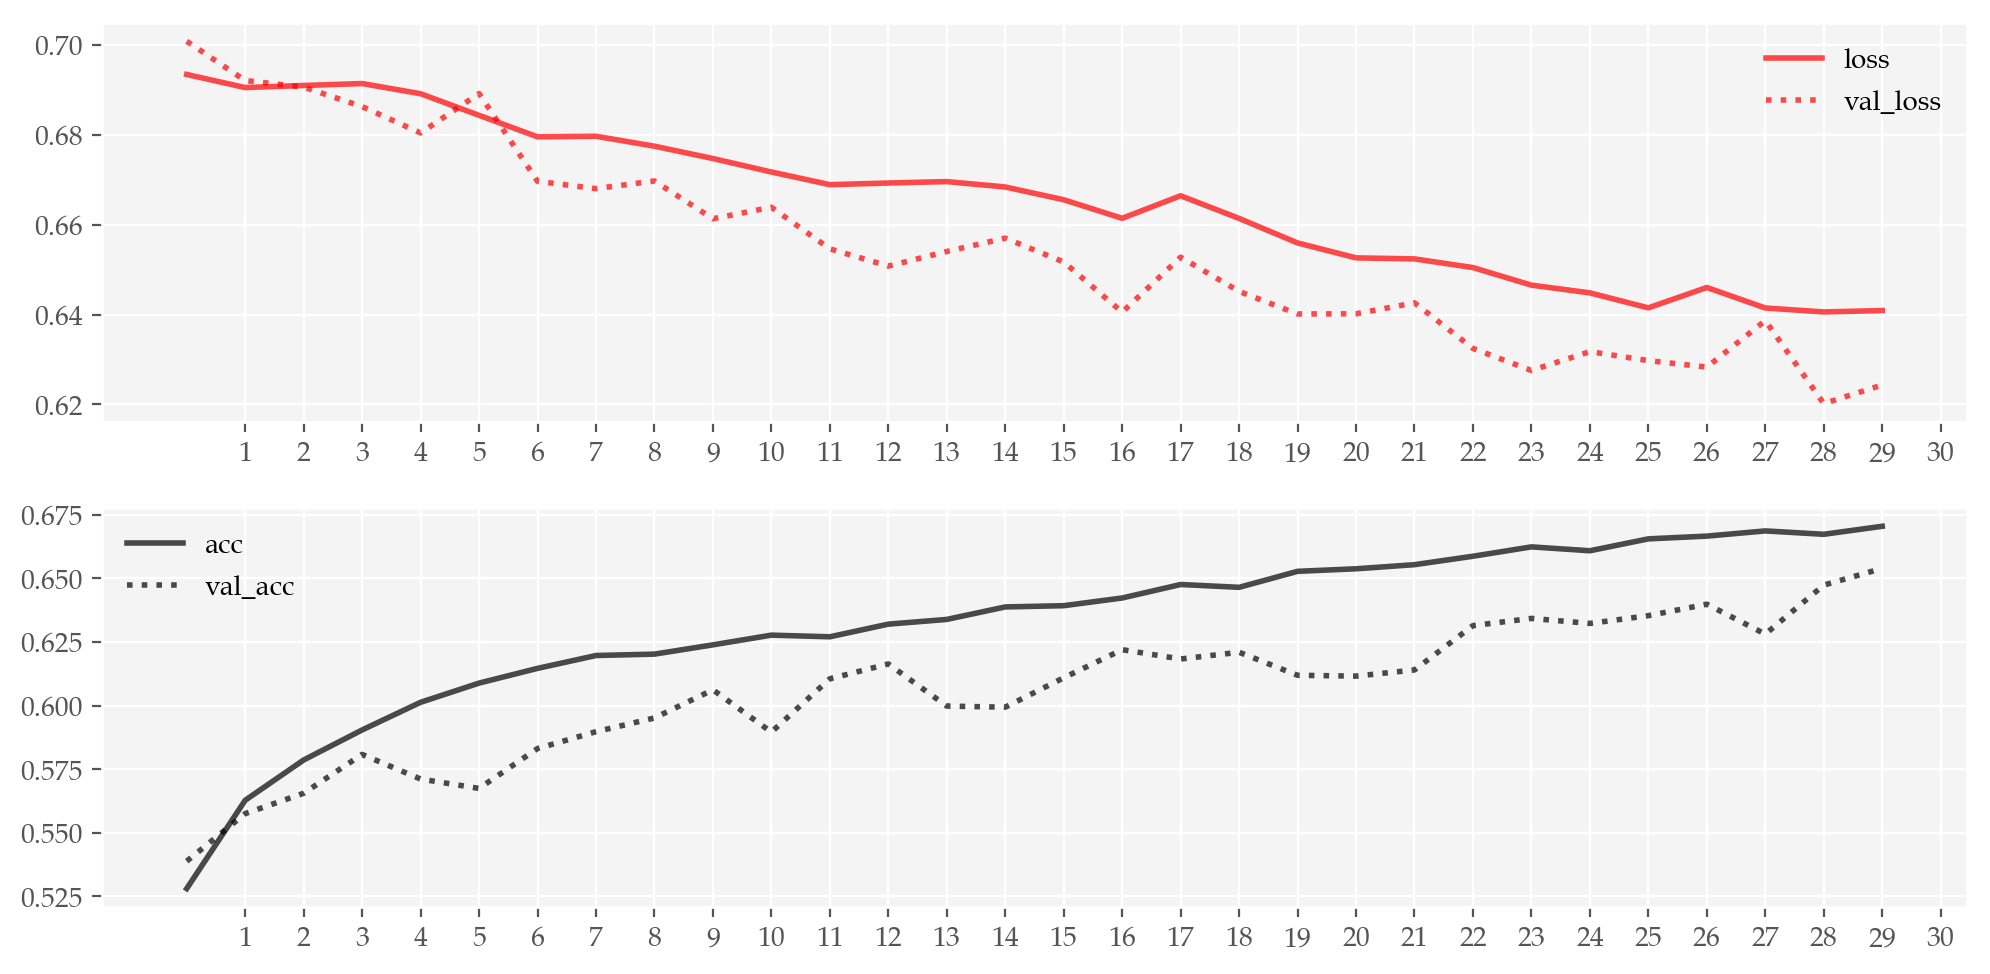

In [883]:
batch_size = 10
epochs = 30
neurons = 32

train_len = len(y_train) - len(y_train) % 50
X_train = X_train[:train_len]
y_train = y_train[:train_len]
test_len = len(y_test) - len(y_test) % 50
X_test = X_test[:test_len]
y_test = y_test[:test_len]

cv_val_len = round(val_len * val_split)
cv_val_len -= cv_val_len % batch_size
nfolds = round(1 / val_split)
idx = np.arange(X_train.shape[0])

np.random.seed(seed)
model = Sequential()
model.add(LSTM(neurons, stateful=True, batch_input_shape=(batch_size, 1, X_train.shape[1]), name='LSTM'))
model.add(Dropout(.2, name='Dropout'))
model.add(Dense(neurons, activation='sigmoid', name='Sigmoid'))
model.add(Dense(1, name='Output'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
t0 = time.time()
width = 20
rightarrow, blacksquare, whitesquare = '>', '#', '='

i = 0
while i < epochs:
    loss, val_loss, acc, val_acc = 0, 0, 0, 0
    for fold in range(nfolds):
        test_mask = np.logical_and(idx >= fold * cv_val_len, idx < (fold + 1) * cv_val_len)
        
        X_train_cv, y_train_cv = sampler.fit_resample(X_train[~test_mask], y_train[~test_mask])
        X_train_cv = X_train_cv.reshape(X_train_cv.shape[0], 1, X_train_cv.shape[1])
        train_len = len(y_train_cv) - len(y_train_cv) % batch_size
        X_train_cv = X_train_cv[:train_len]
        y_train_cv = y_train_cv[:train_len]
        
        X_test_cv, y_test_cv = sampler.fit_resample(X_train[test_mask], y_train[test_mask])
        X_test_cv = X_test_cv.reshape(X_test_cv.shape[0], 1, X_test_cv.shape[1])
        test_len = len(y_test_cv) - len(y_test_cv) % batch_size
        X_test_cv = X_test_cv[:test_len]
        y_test_cv = y_test_cv[:test_len]
        
        model.fit(X_train_cv, y_train_cv, epochs=1, batch_size=batch_size, validation_data=(X_test_cv, y_test_cv), verbose=0)
        loss += model.history.history['loss'][0]
        val_loss += model.history.history['val_loss'][0]
        acc += model.history.history['acc'][0]
        val_acc += model.history.history['val_acc'][0]
    loss /= nfolds
    val_loss /= nfolds
    acc /= nfolds
    val_acc /= nfolds
    dt = time.time() - t0
    progress = (i + 1) / epochs
    eta = dt / progress * (1 - progress)
    nbars = round(width * progress)
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(acc)
    history['val_acc'].append(val_acc)
    msg1 = 'Epoch {}/{} |{}{}{}| - eta: {:.0f}s'.\
    format(i + 1, epochs, blacksquare * nbars, rightarrow, whitesquare * (width - nbars - 1), eta)
    msg2 = 'loss: {:.4f} - val_loss: {:.4f} - acc: {:.4f} - val_acc: {:.4f}'.\
    format(loss, val_loss, acc, val_acc)
    msg = msg1 + ' - ' + msg2
    print('{: <150s}'.format(msg), end='\r')
    i += 1

print(msg.replace(rightarrow, blacksquare))

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(history['loss'], 'r', alpha=.7, label='loss')
ax.plot(history['val_loss'], 'r:', alpha=.7, label='val_loss')
ax.set_xticks(np.arange(epochs) + 1)
ax.legend(frameon=False)
ax = fig.add_subplot(212)
ax.plot(history['acc'], 'k', alpha=.7, label='acc')
ax.plot(history['val_acc'], 'k:', alpha=.7, label='val_acc')
ax.set_xticks(np.arange(epochs) + 1)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

In [884]:
best_score_list.append(history['val_acc'][-1])
estimator_list.append(model)
estimator_name_list.append('LSTM')
best_params_list.append(None)

### 7. Voting

In [895]:
seq = sorted(best_score_list, reverse=True)
rank = [1 + seq.index(s) for s in best_score_list]

res = pd.DataFrame({'model':estimator_name_list, 'score':best_score_list, 'rank':rank},
                   columns=['model', 'score', 'rank']).set_index('model')
res['rank'] = res['rank'].astype('object')
res['weight'] = (res['score'] - res['score'].min()) / (res['score'].max() - res['score'].min())
res.round(3).T

model      LR    LDA     DT    KNN     RF    EXT    ADA    GBM    XGB    SVC  \
score   0.255  0.253  0.602  0.487  0.579  0.274  0.451  0.604  0.609  0.623   
rank       10     11      5      7      6      9      8      4      3      2   
weight  0.005      0  0.871  0.585  0.813  0.054  0.493  0.874  0.888  0.924   

model    LSTM  
score   0.654  
rank        1  
weight      1

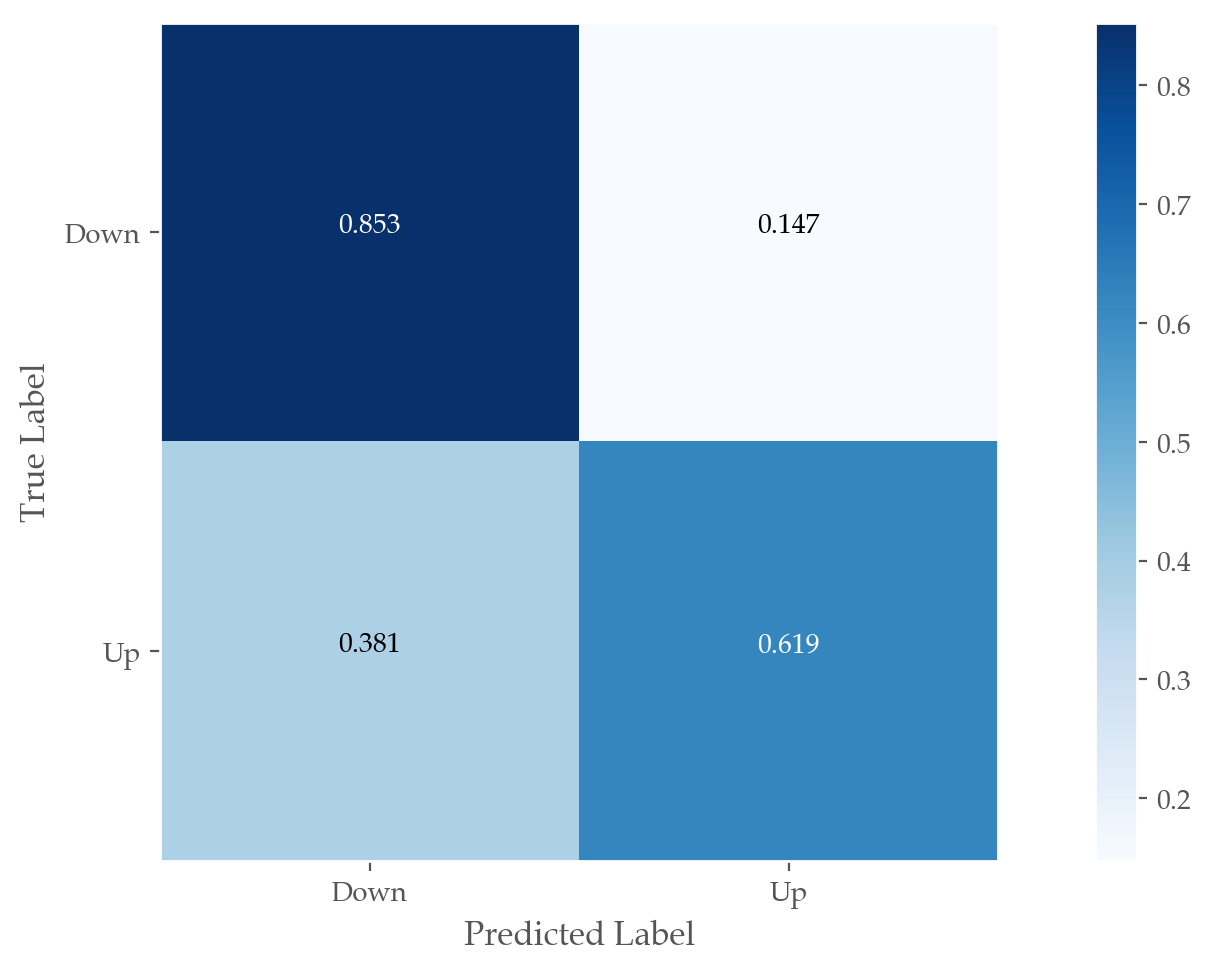

bd       dcs     dcs_1         dcs_2         dcs_3  \
1997-02-28  4.367246  1.703077  0.000000  3.027882e-14 -3.027882e-14   
1997-03-01  4.367246  0.000000  1.703127  0.000000e+00  3.027882e-14   
1997-03-02  4.367246  0.000000  0.000000  1.703127e+00  0.000000e+00   
1997-03-03  4.373548 -0.340888  0.000000  0.000000e+00  1.703127e+00   
1997-03-04  4.392454  0.340888 -0.340898  0.000000e+00  0.000000e+00   
1997-03-05  4.386152 -0.340888  0.340898 -3.408978e-01  0.000000e+00   
1997-03-06  4.405058  0.340888 -0.340898  3.408978e-01 -3.408978e-01   
1997-03-07  4.373548  0.000000  0.340898 -3.408978e-01  3.408978e-01   
1997-03-08  4.373548  0.000000  0.000000  3.408978e-01 -3.408978e-01   
1997-03-09  4.373548  0.000000  0.000000  0.000000e+00  3.408978e-01   
...              ...       ...       ...           ...           ...   
2019-01-14  2.211982  0.340888  0.000000  0.000000e+00  3.408978e-01   
2019-01-15  2.211982 -0.340888  0.340898  0.000000e+00  0.000000e+00   
2019-01-16  2.211982 -0.340888 -0.340898  3.408978e-01  0.000000e+00   
2019-01-17  2.205680 -1.022391 -0.340898 -3.408978e-01  3.408978e-01   
2019-01-18  2.205680 -1.362870 -1.022421 -3.408978e-01 -3.408978e-01   
2019-01-19  2.205680  0.000000 -1.362910 -1.022421e+00 -3.408978e-01   
2019-01-20  2.205680  0.000000  0.000000 -1.362910e+00 -1.022421e+00   
2019-01-21  2.205680  0.000000  0.000000  0.000000e+00 -1.362910e+00   
2019-01-22  2.174170  0.000000  0.000000  0.000000e+00  0.000000e+00   
2019-01-23  2.174170 -0.681708  0.000000  0.000000e+00  0.000000e+00   

                  dr      edcs    edcs_1    edcs_2    edcs_3       spr  \
1997-02-28  0.659966 -0.125902 -0.125490 -0.125080 -0.124672  0.041652   
1997-03-01  0.659441 -0.126316 -0.125902 -0.125490 -0.125080  0.041652   
1997-03-02  0.658917 -0.126731 -0.126315 -0.125901 -0.125490  0.179115   
1997-03-03  0.658392 -0.127149 -0.126731 -0.126315 -0.125901  0.189078   
1997-03-04  0.657867 -0.127569 -0.127149 -0.126731 -0.126315 -0.384305   
1997-03-05  0.657343 -0.127991 -0.127569 -0.127149 -0.126731 -0.316041   
1997-03-06  0.656818 -0.128416 -0.127991 -0.127569 -0.127149 -0.320251   
1997-03-07  0.656294 -0.128842 -0.128415 -0.127991 -0.127569 -0.113315   
1997-03-08  0.655769 -0.129270 -0.128842 -0.128415 -0.127991 -0.113315   
1997-03-09  0.655244 -0.129701 -0.129270 -0.128842 -0.128415 -0.113315   
...              ...       ...       ...       ...       ...       ...   
2019-01-14  0.784896 -0.000363 -0.000363 -0.000363 -0.000363  2.570088   
2019-01-15  0.784398 -0.000363 -0.000363 -0.000363 -0.000363  1.508262   
2019-01-16  0.783899 -0.000363 -0.000363 -0.000363 -0.000363  1.334690   
2019-01-17  0.783401 -0.000363 -0.000363 -0.000363 -0.000363  1.577326   
2019-01-18  0.782902 -0.000363 -0.000363 -0.000363 -0.000363  1.942204   
2019-01-19  0.782403 -0.000363 -0.000363 -0.000363 -0.000363  1.942204   
2019-01-20  0.781905 -0.000363 -0.000363 -0.000363 -0.000363  1.706057   
2019-01-21  0.781406 -0.000363 -0.000363 -0.000363 -0.000363  1.706057   
2019-01-22  0.780908 -0.000363 -0.000363 -0.000363 -0.000363  1.277662   
2019-01-23  0.780409 -0.000363 -0.000363 -0.000363 -0.000363  2.034505   

               spr_3       syc       vix  y  y_hat  
1997-02-28  1.132277  0.508557  2.518605  0      0  
1997-03-01  0.854451  0.508557  2.518605  0      0  
1997-03-02  0.182214  0.508557  2.518605  0      0  
1997-03-03  0.041668  0.508557  2.493538  1      1  
1997-03-04  0.041668  0.530198  2.461310  0      0  
1997-03-05  0.179183  0.508557  2.326427  1      1  
1997-03-06  0.189150  0.508557  2.444599  0      0  
1997-03-07 -0.384451  0.508557  2.306135  0      0  
1997-03-08 -0.316162  0.508557  2.306135  0      0  
1997-03-09 -0.320373  0.508557  2.306135  1      1  
...              ...       ...       ... ..    ...  
2019-01-14  1.940927  0.194767  2.276294  0      0  
2019-01-15  1.940927  0.205587  2.220192  0      0  
2019-01-16  2.722658  0.194767  2.272713  0      0  
2019-01-1

In [896]:
y_hat = {}   # full timespan
y_pred = {}  # only test

max_rank = res['rank'].max()

for name, est, params in zip(estimator_name_list, estimator_list, best_params_list):
    try:
        est = est(**params)
        est.fit(X_train, y_train)
        y_hat['y_hat_' + name] = est.predict(X)
        y_pred['y_hat_' + name] = est.predict(X_test)
    except TypeError:
        y_hat['y_hat_LSTM'] = model.predict_classes(X.reshape(X.shape[0], 1, X.shape[1]),
                                                    batch_size=batch_size).T[0]
        y_pred['y_pred_LSTM'] = model.predict_classes(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]),
                                                      batch_size=batch_size).T[0]

y_hat = np.average(np.array(list(y_hat.values())), axis=0, weights=res['weight']).round().astype('int')
y_pred = np.average(np.array(list(y_pred.values())), axis=0, weights=res['weight']).round().astype('int')

plot_confusion_matrix(y_test, y_pred, ['Down', 'Up'], normalize=True)

df_model['y_hat'] = y_hat
df_model

Click [here](https://github.com/allenfrostline/iaqf2019/blob/master/explore.ipynb) to download this notebook.